# Land Surface Temperature Analysis and Feature Extraction
This notebook demonstrates how to sample, analyze, and extract features from land surface temperature (LST) and multispectral satellite images for the Austin area. Steps include:
- Loading and visualizing LST data
- Sampling random and hotspot points
- Extracting band values from B2-B9 images
- Calculating vegetation and water indices (NDVI, EVI, NDWI)
- Saving the final dataset

In [76]:
# Show only the Land Surface Temperature TIFF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math 
import pandas as pd
import rasterio



## 1. Load and Visualize Land Surface Temperature (LST) Image
We start by loading the LST TIFF image and displaying it to understand the spatial distribution of surface temperature.

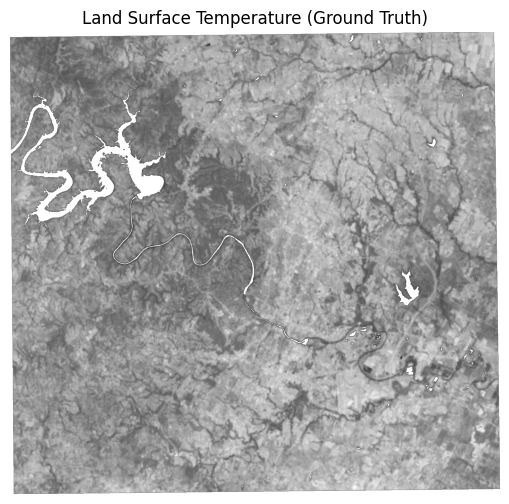

In [77]:
project_path = "/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/PGE_383_TermProject_XihanYao/"
# This image may not be available on github due to its size.
lst_path = project_path + "data/Land_surface_temperature.tif"

img = Image.open(lst_path)
arr = np.array(img)

plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap="gray")
plt.title("Land Surface Temperature (Ground Truth)")
plt.axis("off")
plt.show()

In [78]:
# Estimating the AOI area: 
aoi = [-98.05, 30.10, -97.50, 30.55]  

min_lon, min_lat, max_lon, max_lat = aoi
dlat = max_lat - min_lat   # 0.45°
dlon = max_lon - min_lon   # 0.55°

lat_mid = (min_lat + max_lat) / 2
km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * math.cos(math.radians(lat_mid))

height_km = dlat * km_per_deg_lat
width_km = dlon * km_per_deg_lon

area_km2 = height_km * width_km
print(f"Estimated area_km2: {area_km2:.2f} km²")


Estimated area_km2: 2647.41 km²


In [79]:
sample_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
for size in sample_sizes:
    sample_density = size / area_km2
    print(f"Sample Size: {size}, Sample Density: {sample_density:.2f} samples/km²")

Sample Size: 100, Sample Density: 0.04 samples/km²
Sample Size: 200, Sample Density: 0.08 samples/km²
Sample Size: 300, Sample Density: 0.11 samples/km²
Sample Size: 400, Sample Density: 0.15 samples/km²
Sample Size: 500, Sample Density: 0.19 samples/km²
Sample Size: 600, Sample Density: 0.23 samples/km²
Sample Size: 700, Sample Density: 0.26 samples/km²
Sample Size: 800, Sample Density: 0.30 samples/km²
Sample Size: 900, Sample Density: 0.34 samples/km²
Sample Size: 1000, Sample Density: 0.38 samples/km²
Sample Size: 1100, Sample Density: 0.42 samples/km²
Sample Size: 1200, Sample Density: 0.45 samples/km²
Sample Size: 1300, Sample Density: 0.49 samples/km²
Sample Size: 1400, Sample Density: 0.53 samples/km²
Sample Size: 1500, Sample Density: 0.57 samples/km²
Sample Size: 1600, Sample Density: 0.60 samples/km²
Sample Size: 1700, Sample Density: 0.64 samples/km²
Sample Size: 1800, Sample Density: 0.68 samples/km²
Sample Size: 1900, Sample Density: 0.72 samples/km²
Sample Size: 2000, Sa

## 2. Sample 2000 Random Points from LST Image
We assume there are ground truth measurment points on the ground.
Randomly select 2000 valid pixels from the LST image and store their coordinates and temperature values in a DataFrame.
Note there are no samples taken from the water body. That is reasonable.

In [80]:
# Select 2000 random samples from img and save coordinates/values in a DataFrame
import numpy as np
import pandas as pd
import rasterio

arr = np.array(img)
with rasterio.open(lst_path) as src:
    transform = src.transform

mask = np.isfinite(arr)
rows, cols = np.where(mask)
np.random.seed(42)
idx = np.random.choice(len(rows), size=2000, replace=False)
sample_rows = rows[idx]
sample_cols = cols[idx]
sample_vals = arr[sample_rows, sample_cols]
xs, ys = rasterio.transform.xy(transform, sample_rows, sample_cols)

df = pd.DataFrame({
    "row": sample_rows,
    "col": sample_cols,
    "x": xs,
    "y": ys,
    "land surface temperature": sample_vals
})

df.to_csv("LST_random_samples_2000.csv", index=False)
df.head()

,row,col,x,y,land surface temperature
0,264,603,609195.0,3372765.0,314.244171
1,725,924,618825.0,3358935.0,320.116333
2,775,467,605115.0,3357435.0,320.670044
3,1014,538,607245.0,3350265.0,319.979614
4,37,539,607275.0,3379575.0,317.559662


### Visualize Random Sample Points
Overlay the 2000 random sample points on the LST image to check their spatial distribution.

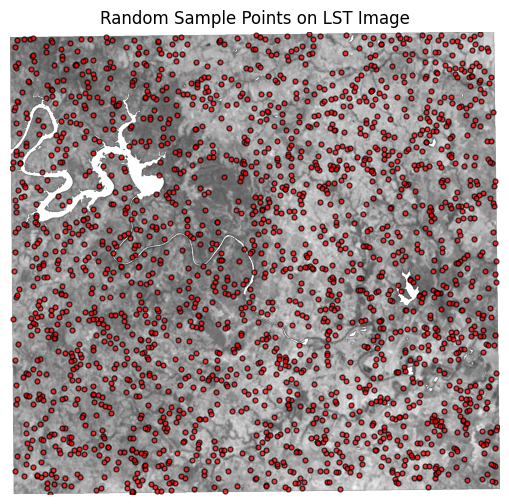

In [81]:
import matplotlib.pyplot as plt

# Plot the image and overlay the sample points
plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap="gray")
plt.scatter(sample_cols, sample_rows, s=12, c="red", edgecolor="black", alpha=0.7)
plt.title("Random Sample Points on LST Image")
plt.axis("off")
plt.show()

## 3. Generate Hotspot-Biased Samples
To ensure we capture data from areas with high temperatures, we will generate an additional 2000 samples biased towards the hotter regions identified in the initial random sample. This is done by using the hottest 35% of the random samples as "seeds" and generating new sample points in their vicinity, with more points allocated to hotter seeds.

Generated samples: 1924
Saved to LST_temp_weighted_samples_2000.csv


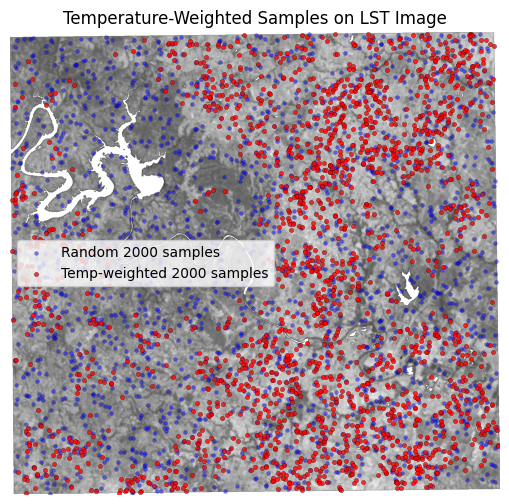

In [82]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import xy
import matplotlib.pyplot as plt

# ------------------------------
# Load Raster & Previous Samples
# ------------------------------
with rasterio.open(lst_path) as src:
    arr = src.read(1)
    transform = src.transform
    height, width = arr.shape

df_prev = pd.read_csv("LST_random_samples_2000.csv")

# ------------------------------
# Select the Hot Seeds (top 35%)
# ------------------------------
th = df_prev["land surface temperature"].quantile(0.65)
hot_df = df_prev[df_prev["land surface temperature"] >= th].reset_index(drop=True)

temps = hot_df["land surface temperature"].to_numpy()
# Normalize weights (sum to 1)
weights = temps / temps.sum()

# ------------------------------
# Allocate EXACTLY 2000 samples
# ------------------------------
target = 2000
alloc = np.floor(weights * target).astype(int)

# Fix rounding: ensure sum = target
diff = target - alloc.sum()
if diff > 0:
    # distribute remaining counts to highest temps
    extra_idx = np.argsort(weights)[-diff:]
    alloc[extra_idx] += 1

# ------------------------------
# Sampling Radius
# ------------------------------
R = 75
rng = np.random.default_rng(42)
seen = set()
samples = []

# ------------------------------
# Generate Samples
# ------------------------------
for i, row in hot_df.iterrows():
    seed_r = int(row["row"])
    seed_c = int(row["col"])
    n_i = alloc[i]

    for _ in range(n_i):
        # random offset inside a circle
        angle = rng.uniform(0, 2*np.pi)
        dist  = rng.uniform(0, R)

        rr = seed_r + int(dist * np.sin(angle))
        cc = seed_c + int(dist * np.cos(angle))

        if rr < 0 or rr >= height or cc < 0 or cc >= width:
            continue
        if not np.isfinite(arr[rr, cc]):
            continue
        key = (rr, cc)
        if key in seen:
            continue

        seen.add(key)
        samples.append((rr, cc, float(arr[rr, cc])))

    # Stop early if we reached the target
    if len(samples) >= target:
        break

# Trim if slightly overshoot (rare)
samples = samples[:target]

print("Generated samples:", len(samples))

# ------------------------------
# Convert to Coordinates
# ------------------------------
rows = [s[0] for s in samples]
cols = [s[1] for s in samples]
xs, ys = rasterio.transform.xy(transform, rows, cols)

out = pd.DataFrame({
    "row": rows,
    "col": cols,
    "x": xs,
    "y": ys,
    "land surface temperature": [s[2] for s in samples]
})

out.to_csv("LST_temp_weighted_samples_2000.csv", index=False)
print("Saved to LST_temp_weighted_samples_2000.csv")

# ------------------------------
# Plot (same style as before)
# ------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap="gray")
plt.scatter(df_prev["col"], df_prev["row"], s=8, c="blue", edgecolor="black", linewidth=0.2, alpha=0.5, label="Random 2000 samples")
plt.scatter(out["col"], out["row"], s=10, c="red", edgecolor="black", linewidth=0.2, alpha=0.8, label="Temp-weighted 2000 samples")

plt.legend()
plt.title("Temperature-Weighted Samples on LST Image")
plt.axis("off")
plt.show()


In [83]:
df_2000 = pd.read_csv("LST_random_samples_2000.csv")
df_hot = pd.read_csv("LST_temp_weighted_samples_2000.csv")

## 4. Combine and Visualize All Sample Points
Merge the random and hotspot-biased sample DataFrames into a single DataFrame for further analysis.

In [84]:
df = pd.concat([df_2000, df_hot], ignore_index=True)
df.tail(5)

,row,col,x,y,land surface temperature
3919,402,1161,625935.0,3368625.0,324.522156
3920,417,1151,625635.0,3368175.0,325.062225
3921,1641,602,609165.0,3331455.0,324.710144
3922,1659,630,610005.0,3330915.0,323.623230
3923,1651,595,608955.0,3331155.0,323.872742


### Visualize Combined Sample Points by Temperature
Plot all sample points on the LST image, coloring each point by its temperature value.

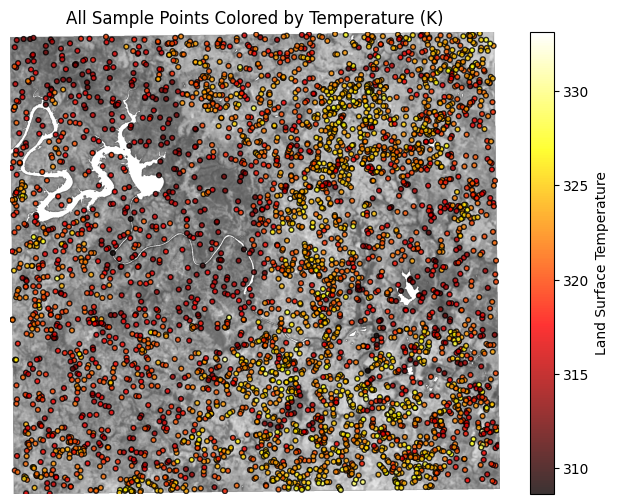

In [85]:
plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap="gray")
sc = plt.scatter(df["col"], df["row"], c=df["land surface temperature"], cmap="hot", s=12, edgecolor="black", alpha=0.8)
plt.colorbar(sc, label="Land Surface Temperature")
plt.title("All Sample Points Colored by Temperature (K)")
plt.axis("off")
plt.show()

## 5. Extract Multispectral Band Values and Calculate Indices
For each sample point, extract the pixel value from bands B2 to B9, calculate vegetation and water indices, and add them as new columns in the DataFrame.

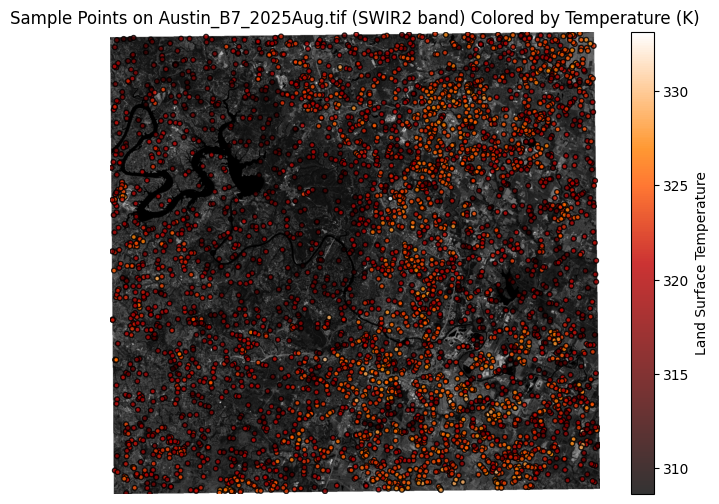

In [86]:

# Load the new TIFF image
b2_path = "/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/PGE_383_TermProject_XihanYao/data/Austin_B7_2025Aug.tif"
with rasterio.open(b2_path) as src:
    b2_arr = src.read(1)

plt.figure(figsize=(8, 6))
plt.imshow(b2_arr, cmap="gray")
sc = plt.scatter(df["col"], df["row"], c=df["land surface temperature"], cmap="gist_heat", s=12, edgecolor="black", alpha=0.8)
plt.colorbar(sc, label="Land Surface Temperature")
plt.title("Sample Points on Austin_B7_2025Aug.tif (SWIR2 band) Colored by Temperature (K)")
plt.axis("off")
plt.show()

### Extract Band Values and Rename Columns
Extract values from each band image (B2-B9) for all sample points and assign descriptive names to the new columns.

In [87]:
import rasterio

band_names = {
    2: "B2_blue",
    3: "B3_green",
    4: "B4_red",
    5: "B5_NIR",
    6: "B6_SWIR1",
    7: "B7_SWIR2",
    8: "B8_pan",
    9: "B9_cirrus"
}

# Add new columns with correct names
for band, name in band_names.items():
    tif_path = f"/Users/xy5226/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Courses/PGE 383/PGE_383_TermProject_XihanYao/data/Austin_B{band}_2025Aug.tif"
    with rasterio.open(tif_path) as src:
        arr = src.read(1)
        df[name] = arr[df["row"], df["col"]]

df.tail(5)

,row,col,x,y,land surface temperature,B2_blue,B3_green,B4_red,B5_NIR,B6_SWIR1,B7_SWIR2,B8_pan,B9_cirrus
3919,402,1161,625935.0,3368625.0,324.522156,0.343863,0.305664,0.294550,0.533043,0.342576,0.223788,0.160471,0.001534
3920,417,1151,625635.0,3368175.0,325.062225,0.349245,0.356557,0.381535,0.713332,0.453448,0.299522,0.125149,0.001045
3921,1641,602,609165.0,3331455.0,324.710144,0.263605,0.247576,0.251028,0.773174,0.473961,0.245471,0.094784,0.001045
3922,1659,630,610005.0,3330915.0,323.623230,0.266998,0.252666,0.250384,0.851034,0.490691,0.230690,0.093917,0.001334
3923,1651,595,608955.0,3331155.0,323.872742,0.246640,0.218562,0.189138,0.730705,0.407976,0.196255,0.098141,0.001289


### Calculate Vegetation and Water Indices
Compute NDVI, EVI, and NDWI for each sample point using the extracted band values.

In [88]:
# NDVI: (NIR - Red) / (NIR + Red)
df["NDVI"] = (df["B5_NIR"] - df["B4_red"]) / (df["B5_NIR"] + df["B4_red"])

# EVI: 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
df["EVI"] = 2.5 * (df["B5_NIR"] - df["B4_red"]) / (
    df["B5_NIR"] + 6 * df["B4_red"] - 7.5 * df["B2_blue"] + 1
)

# NDWI: (Green - NIR) / (Green + NIR)
df["NDWI"] = (df["B3_green"] - df["B5_NIR"]) / (df["B3_green"] + df["B5_NIR"])
df.tail(5)

,row,col,x,y,land surface temperature,B2_blue,B3_green,B4_red,B5_NIR,B6_SWIR1,B7_SWIR2,B8_pan,B9_cirrus,NDVI,EVI,NDWI
3919,402,1161,625935.0,3368625.0,324.522156,0.343863,0.305664,0.294550,0.533043,0.342576,0.223788,0.160471,0.001534,0.288177,0.826530,-0.271106
3920,417,1151,625635.0,3368175.0,325.062225,0.349245,0.356557,0.381535,0.713332,0.453448,0.299522,0.125149,0.001045,0.303047,0.599687,-0.333469
3921,1641,602,609165.0,3331455.0,324.710144,0.263605,0.247576,0.251028,0.773174,0.473961,0.245471,0.094784,0.001045,0.509808,1.002350,-0.514913
3922,1659,630,610005.0,3330915.0,323.623230,0.266998,0.252666,0.250384,0.851034,0.490691,0.230690,0.093917,0.001334,0.545342,1.111608,-0.542148
3923,1651,595,608955.0,3331155.0,323.872742,0.246640,0.218562,0.189138,0.730705,0.407976,0.196255,0.098141,0.001289,0.588761,1.332955,-0.539515


## 6. Save Final Dataset
Export the DataFrame with all sample points, band values, and indices to a CSV file for further analysis.

In [89]:
df.to_csv("LST_samples_with_bands_and_indices.csv", index=False)